# Advanced Regression Pipeline

This notebook builds on the LightGBM pipeline to compare three regression algorithms using data from the local database. It includes data loading, preprocessing, model training, evaluation, and visualization.

In [1]:
import os
import json
import math
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple

## Environment
from dotenv import load_dotenv

## Core Scientific Stack
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Database
import psycopg2

## Machine Learning / Preprocessing (scikit-learn)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, Pipeline as SkPipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Gradient Boosting Libraries
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor

## Deep Learning / Tabular
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tabnet.tab_model import TabNetRegressor

## Optimization & Persistence
import optuna
import joblib

# Load environment variables from .env file
load_dotenv(override=True)

# Setup model directory (handle notebook environment where __file__ is undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # Fallback: assume notebook is inside src; go up one directory if so
    cwd = Path.cwd().resolve()
    if (cwd / 'supervised.ipynb').exists() or (cwd / 'unsupervised.ipynb').exists():
        PROJECT_ROOT = cwd
    else:
        for parent in cwd.parents:
            if (parent / 'requirements.txt').exists() or (parent / 'README.md').exists():
                PROJECT_ROOT = parent / 'src'
                break
        else:
            PROJECT_ROOT = cwd  # final fallback

MODEL_DIR = (PROJECT_ROOT / '..' / 'supervised').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

def save_model(model, name: str, extra: dict | None = None):
    """Utility to persist models and optional metadata alongside them.
    Saves model as joblib plus a companion JSON with metadata/hyperparams.
    For PyTorch models, saves state_dict separately to avoid pickling issues."""
    timestamp = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    base_name = f"{name}_{timestamp}"
    
    # Check if this is a PyTorch-based model
    is_torch_model = hasattr(model, 'model_') and isinstance(model.model_, nn.Module)
    
    if is_torch_model:
        # Save PyTorch model state separately
        model_path = MODEL_DIR / f"{base_name}.pt"
        params_path = MODEL_DIR / f"{base_name}_params.json"
        
        # Save the model state dict and parameters
        torch.save({
            'model_state_dict': model.model_.state_dict(),
            'model_params': model.get_params(),
            'n_features_in': getattr(model, 'n_features_in_', None),
            'device': getattr(model, '_device_', 'cpu')
        }, model_path)
        
        # Save initialization parameters for recreation
        with open(params_path, 'w') as f:
            json.dump(model.get_params(), f, indent=2)
            
        print(f"Saved PyTorch model -> {model_path.name}; params -> {params_path.name}")
    else:
        # Use joblib for non-PyTorch models
        model_path = MODEL_DIR / f"{base_name}.joblib"
        joblib.dump(model, model_path)
        print(f"Saved model -> {model_path.name}")
    
    # Save metadata
    meta_path = MODEL_DIR / f"{base_name}.json"
    meta = {'model_name': name, 'saved_utc': timestamp, 'is_torch_model': is_torch_model}
    
    if extra:
        # Deep copy and convert non-serializable objects
        extra_clean = {}
        for k, v in extra.items():
            try:
                # Test if value is JSON serializable
                json.dumps(v)
                extra_clean[k] = v
            except TypeError:
                # Handle TabNet History objects and other non-serializable types
                if hasattr(v, 'history') and hasattr(v, 'epoch'):
                    # TabNet History object - extract the history dict
                    extra_clean[k] = getattr(v, 'history', {})
                elif hasattr(v, '__dict__'):
                    # Try to extract dict representation
                    try:
                        dict_repr = {attr: getattr(v, attr) for attr in dir(v) 
                                   if not attr.startswith('_') and not callable(getattr(v, attr))}
                        # Test if the dict is serializable
                        json.dumps(dict_repr)
                        extra_clean[k] = dict_repr
                    except (TypeError, AttributeError):
                        extra_clean[k] = str(v)  # Fallback to string representation
                else:
                    extra_clean[k] = str(v)  # Fallback to string representation
        meta.update(extra_clean)
    
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved metadata -> {meta_path.name}")

# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available - PyTorch will use CPU only")
    print("To enable GPU training, install PyTorch with CUDA support:")
    print("  conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia")
    print("  or")
    print("  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
# Display versions
print('LightGBM version:', lgb.__version__)
print('XGBoost version:', xgb.__version__)

Models will be saved to: D:\docs\MADS\696-Milestone 2\supervised
PyTorch version: 2.5.1
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1660 Ti
LightGBM version: 4.6.0
XGBoost version: 3.0.5


### TabNet Class Definitions (Early Load)
Define TabNet wrapper class here before auto-load cell to support unpickling saved models.

In [2]:
# TabNet wrapper class - defined early for joblib unpickling compatibility
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

def prepare_data_for_tabnet(X, y=None):
    """Convert data to TabNet-compatible format."""
    X_dense = X.toarray().astype(np.float32) if hasattr(X, 'toarray') else np.asarray(X, dtype=np.float32)
    if y is not None:
        y_arr = np.asarray(y)
        y_reshaped = y_arr.reshape(-1, 1) if y_arr.ndim == 1 else y_arr
        return X_dense, y_reshaped
    return X_dense

class SimpleTabNetWrapper(BaseEstimator, RegressorMixin):
    """Simplified TabNet wrapper with sensible defaults."""
    
    def __init__(self, n_d=16, n_a=16, n_steps=5, gamma=1.3, lambda_sparse=1e-4, 
                 lr=0.02, max_epochs=100, patience=20, batch_size=1024, seed=42):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.lr = lr
        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.seed = seed
        self.model_ = None

    def fit(self, X, y):
        from pytorch_tabnet.tab_model import TabNetRegressor
        
        X_prep, y_prep = prepare_data_for_tabnet(X, y)
        
        # Create internal validation split (15% for early stopping)
        n_samples = X_prep.shape[0]
        val_size = max(1, int(n_samples * 0.15))
        rng = np.random.default_rng(self.seed)
        indices = rng.permutation(n_samples)
        
        train_idx, val_idx = indices[val_size:], indices[:val_size]
        X_train, y_train = X_prep[train_idx], y_prep[train_idx]
        X_val, y_val = X_prep[val_idx], y_prep[val_idx]
        
        self.model_ = TabNetRegressor(
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps,
            gamma=self.gamma, lambda_sparse=self.lambda_sparse,
            optimizer_params={'lr': self.lr}, seed=self.seed
        )
        
        self.model_.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=['rmse'],
            max_epochs=self.max_epochs,
            patience=self.patience,
            batch_size=self.batch_size,
            virtual_batch_size=128
        )
        self.history_ = self.model_.history
        return self

    def predict(self, X):
        check_is_fitted(self, 'model_')
        X_prep = prepare_data_for_tabnet(X)
        return self.model_.predict(X_prep).ravel()

print("✓ SimpleTabNetWrapper class defined")

✓ SimpleTabNetWrapper class defined


### Auto Load / Conditional Training
If a previously saved optimized model exists in `src/supervised`, the notebook will load the most recent artifact (by timestamp in filename) and skip retraining unless `FORCE_RETRAIN=True`.

In [3]:
# Auto-load previously saved optimized models (XGBoost / RandomForest / SVR / LinearRegression / Polynomial / MLP / TabNet)
from pathlib import Path as _Path
import json as _json

FORCE_RETRAIN = False
FAST_MODE = True
QUICK_TRIALS = 2 if FAST_MODE else 5  # Reduce Optuna trials
QUICK_EPOCHS = 80 if FAST_MODE else 100  # Reduce neural network epochs
QUICK_CV = 2 if FAST_MODE else 3  # Reduce cross-validation folds
USE_BASELINE_ONLY = False  # Skip hyperparameter optimization entirely

print(f"FAST_MODE: {FAST_MODE}")
print(f"Optuna trials: {QUICK_TRIALS}, Max epochs: {QUICK_EPOCHS}, CV folds: {QUICK_CV}")
print(f"Baseline only: {USE_BASELINE_ONLY}")

# Quick baseline parameters (no optimization)
BASELINE_PARAMS = {
    'xgb': {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
    'rf': {'n_estimators': 100, 'max_depth': 10, 'oob_score': True},
    'svr': {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    'mlp': {'hidden_layer_sizes': (128, 64), 'max_iter': 100, 'early_stopping': True},
    'tabnet': {'n_d': 16, 'n_a': 16, 'max_epochs': 50, 'patience': 10}
}

# Only set to None if not defined to avoid clobbering models loaded earlier in session
if 'xgb_model' not in globals():
    xgb_model = None
if 'rf_model' not in globals():
    rf_model = None
if 'mlp_model' not in globals():
    mlp_model = None
if 'tabnet_model' not in globals():
    tabnet_model = None  # Will delay loading until wrapper class defined
if 'svr_model' not in globals():
    svr_model = None
if 'lr_model' not in globals():
    lr_model = None
if 'poly_model' not in globals():
    poly_model = None

MODEL_GLOB_PATTERNS = {
    'xgb_model': 'xgboost_opt_*.joblib',
    'rf_model': 'random_forest_opt_*.joblib', 
    'mlp_model': 'mlp_opt_*.pt',  # Changed to .pt for PyTorch models
    'tabnet_model': 'tabnet_opt_*.joblib',  # Now loading TabNet here
    'svr_model': 'svr_opt_*.joblib',
    'lr_model': 'linear_regression_opt_*.joblib',
    'poly_model': 'poly_reg_opt_*.joblib'
}

loaded_flags = {}
for var, pattern in MODEL_GLOB_PATTERNS.items():
    if globals().get(var) is not None:
        loaded_flags[var] = 'pre-existing'
        continue
    matches = list(MODEL_DIR.glob(pattern))
    if not matches:
        loaded_flags[var] = 'not found'
        continue
    # Sort by modification time to get the truly latest file
    latest = max(matches, key=lambda p: p.stat().st_mtime)
    try:
        # Special handling for PyTorch models
        if pattern.endswith('.pt'):
            # Load PyTorch model state
            checkpoint = torch.load(latest, map_location='cpu')
            model_params = checkpoint['model_params']
            
            # Recreate the model (assumes TorchMLPRegressor class is defined)
            if 'mlp' in var:
                from sklearn.base import BaseEstimator, RegressorMixin
                # Model will be recreated when needed - just store params for now
                globals()[f"{var}_params"] = model_params
                globals()[f"{var}_checkpoint"] = checkpoint
                loaded_flags[var] = f"✓ {latest.name} (PyTorch checkpoint)"
                print(f" {var}: {latest} (will be recreated on use)")
                globals()[var] = None  # Will recreate later
                continue
        
        # Standard joblib loading (skip TabNet if it will fail)
        if 'tabnet' in var:
            # Check metadata first to see if it's compatible
            meta_file = latest.with_suffix('.json')
            if meta_file.exists():
                with open(meta_file) as f:
                    meta = _json.load(f)
                model_type = meta.get('model_type', 'unknown')
                # Only load if it's the correct wrapper class
                if model_type != 'SimpleTabNetWrapper':
                    loaded_flags[var] = f'skipped (old class: {model_type})'
                    globals()[var] = None
                    print(f" {var}: Skipping incompatible model ({model_type}), will retrain")
                    continue
        
        globals()[var] = joblib.load(latest)
        meta_file = latest.with_suffix('.json')
        if meta_file.exists():
            with open(meta_file) as f:
                globals()[f"{var}_meta"] = _json.load(f)
        # Show the actual file that was loaded
        loaded_flags[var] = f"✓ {latest.name}"
        print(f"  {var}: {latest}")
    except Exception as e:
        loaded_flags[var] = f"failed: {e}";
        globals()[var] = None

print("\nAuto-load status:")
for k,v in loaded_flags.items():
    print(f"  {k}: {v}")
print(f"\nFORCE_RETRAIN = {FORCE_RETRAIN}")

FAST_MODE: True
Optuna trials: 2, Max epochs: 80, CV folds: 2
Baseline only: False
  xgb_model: D:\docs\MADS\696-Milestone 2\supervised\xgboost_opt_refit_20251013T002313Z.joblib
  rf_model: D:\docs\MADS\696-Milestone 2\supervised\random_forest_opt_refit_20251013T002313Z.joblib
 mlp_model: D:\docs\MADS\696-Milestone 2\supervised\mlp_opt_refit_20251013T000918Z.pt (will be recreated on use)
  tabnet_model: D:\docs\MADS\696-Milestone 2\supervised\tabnet_opt_20251013T002309Z.joblib
  svr_model: D:\docs\MADS\696-Milestone 2\supervised\svr_opt_refit_20251013T002304Z.joblib
  lr_model: D:\docs\MADS\696-Milestone 2\supervised\linear_regression_opt_refit_20251013T002304Z.joblib
  poly_model: D:\docs\MADS\696-Milestone 2\supervised\poly_reg_opt_20251012T222954Z.joblib

Auto-load status:
  xgb_model: ✓ xgboost_opt_refit_20251013T002313Z.joblib
  rf_model: ✓ random_forest_opt_refit_20251013T002313Z.joblib
  mlp_model: ✓ mlp_opt_refit_20251013T000918Z.pt (PyTorch checkpoint)
  tabnet_model: ✓ tabnet

C:\Users\Leo\AppData\Local\Temp\ipykernel_28760\4264350029.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest, map_location='cpu')


1. **FAST_MODE**: Reduces trials, epochs, and CV folds
2. **USE_BASELINE_ONLY**: Skip hyperparameter optimization completely
3. **GPU Acceleration**: XGBoost and PyTorch models use CUDA when available
4. **Early Stopping**: Neural networks stop training when validation doesn't improve
5. **Reduced Parameter Spaces**: Fewer options to search through
6. **Parallel Processing**: Multiple CPU cores for most models (except TabNet)

### To run even faster:
- Set `USE_BASELINE_ONLY = True` for instant results with default parameters
- Reduce dataset size by sampling: `df = df.sample(frac=0.5, random_state=42)`
- Use fewer features by selecting only the most important ones
- Skip some models entirely by setting their variables to `None`

In [4]:
# Connect to database and load data
try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.base_data;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    
    # SPEED OPTIMIZATION: Sample data for faster training
    if FAST_MODE and len(df) > 1000:
        sample_size = min(1000, len(df))
        df = df.sample(n=sample_size, random_state=42)
        print(f"FAST_MODE: Sampled {sample_size} rows from {len(df)} total rows")
    
    print(f"Golden data loaded into DataFrame: {df.shape}")
except Exception as e:
    print(f"An error occurred: {e}")

Database connection successful


C:\Users\Leo\AppData\Local\Temp\ipykernel_28760\348372490.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


FAST_MODE: Sampled 1000 rows from 1000 total rows
Golden data loaded into DataFrame: (1000, 18)


## 3. Data Splitting: Train, Validation, Test
Split the dataset into train, validation, and test sets, ensuring proper handling of the target variable.

In [5]:
# Define target and drop missing
TARGET = 'math_high_pct' if 'math_high_pct' in df.columns else 'target'
data = df.dropna().reset_index(drop=True)
data = data.set_index('school_name')

# Split features and target
feature_cols = [c for c in data.columns if c != TARGET 
                and c != 'dup_rank' 
                and c != 'math_low_pct' 
                and c != 'reading_low_pct' 
                and c != 'match_']
X = data[feature_cols]
y = data[TARGET]

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}')

Train shape: (543, 15), Validation shape: (181, 15), Test shape: (182, 15)


## 4. Feature Engineering and Preprocessing Pipeline
Identify numeric and categorical features, set up StandardScaler and OneHotEncoder, and build a ColumnTransformer pipeline.

In [6]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_valid_enc = preprocessor.transform(X_valid)
X_test_enc = preprocessor.transform(X_test)

Numeric features: ['teachers_fte', 'enrollment', 'grade_eight_enrollment', 'math_counts', 'read_counts', 'read_high_pct', 'pct_hhi_150k_200k', 'pct_hhi_220k_plus', 'avg_natwalkind', 'total_10_14', 'pct_10_14', 'pct_female_10_14', 'total_pop', 'schools_in_zip']
Categorical features: ['school_type']


## Model Optimization function

In [7]:
# Reusable Optuna-based optimizer for cross-validated hyperparameter tuning
from typing import Callable, Dict, Tuple

def optimize_model_with_optuna(
                                model_name: str,
                                estimator_builder: Callable[[Dict], object],
                                param_space_fn: Callable[[optuna.trial.Trial], Dict],
                                X,
                                y,
                                scoring: str = 'neg_root_mean_squared_error',
                                cv: int = 3,
                                n_trials: int = 5,
                                direction: str = 'minimize',
                                random_state: int = 42,
                                n_jobs: int = -1,
                            ) -> Tuple[optuna.study.Study, Dict]:
    """Optimize a model's hyperparameters using Optuna and cross-validation.

    Args:
        model_name: Name used to label the Optuna study
        estimator_builder: Callable that receives a params dict and returns an unfitted estimator
        param_space_fn: Callable that maps an Optuna trial to a hyperparameter dictionary
        X, y: Training features and targets used for cross-validation
        scoring: scikit-learn scoring string guiding optimization
        cv: Number of cross-validation folds
        n_trials: Number of Optuna trials to run
        direction: 'minimize' or 'maximize' depending on the objective
        random_state: Seed for the Optuna sampler
        n_jobs: Parallelism for cross_val_score

    Returns:
        The completed Optuna study and the best hyperparameters discovered.
    """
    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(study_name=f"{model_name}_opt", direction=direction, sampler=sampler)

    def objective(trial: optuna.trial.Trial) -> float:
        params = param_space_fn(trial)
        estimator = estimator_builder(params)
        scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
        mean_score = np.mean(scores)
        normalized_score = -mean_score if scoring.startswith('neg') else mean_score
        return normalized_score if direction == 'minimize' else -normalized_score

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study, study.best_params

## LINEAR MODELS

In [8]:
# Manual learning curve function for sklearn models
def get_sklearn_learning_curve(model, X_train, y_train, X_valid, y_valid, n_steps=10):
    train_errors, val_errors = [], []
    train_sizes = np.linspace(0.1, 1.0, n_steps)
    
    for train_size in train_sizes:
        n_samples = int(train_size * len(X_train))
        if n_samples < 1: continue
            
        X_train_subset, y_train_subset = X_train[:n_samples], y_train[:n_samples]
        
        model.fit(X_train_subset, y_train_subset)
        
        train_pred = model.predict(X_train_subset)
        val_pred = model.predict(X_valid)
        
        train_errors.append(np.sqrt(mean_squared_error(y_train_subset, train_pred)))
        val_errors.append(np.sqrt(mean_squared_error(y_valid, val_pred)))
        
    return {'train_rmse': train_errors, 'val_rmse': val_errors, 'train_sizes': train_sizes.tolist()}

# Linear & Kernel-based Models: SVR + Polynomial Regression (with Optuna tuning + CV)
def build_svr_estimator(params: Dict) -> SVR:
    base = {'kernel': params.get('kernel', 'rbf')}
    # Map params safely
    for k in ['C','epsilon','gamma','degree']:
        if k in params:
            base[k] = params[k]
    return SVR(**base)

def svr_param_space(trial: optuna.trial.Trial) -> Dict:
    kernel = trial.suggest_categorical('kernel', ['rbf','poly','sigmoid'])
    params = {
        'kernel': kernel,
        'C': trial.suggest_float('C', 0.5, 10, log=True),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.3),
    }
    if kernel in ['rbf','sigmoid']:
        params['gamma'] = trial.suggest_float('gamma', 0.1, 0.5, log=True)
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
        params['gamma'] = trial.suggest_float('gamma', 0.1, 1, log=True)
    return params

# Run / reuse SVR optimization
if svr_model is None or FORCE_RETRAIN:
    print('[SVR] Starting Optuna optimization...')
    svr_study, svr_best_params = optimize_model_with_optuna(
        model_name='SVR',
        estimator_builder=build_svr_estimator,
        param_space_fn=svr_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1,
    )
    print('Best SVR params:', svr_best_params)
    svr_model = build_svr_estimator(svr_best_params)
    svr_model.fit(X_train_enc, y_train)
    svr_learning_curves = get_sklearn_learning_curve(svr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    svr_valid_pred = svr_model.predict(X_valid_enc)
    svr_test_pred = svr_model.predict(X_test_enc)
    save_model(svr_model, 'svr_opt', {'best_params': svr_best_params, 'learning_curves': svr_learning_curves})
else:
    print('[SVR] Using preloaded optimized model; generating predictions.')
    svr_learning_curves = get_sklearn_learning_curve(svr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    svr_valid_pred = svr_model.predict(X_valid_enc)
    svr_test_pred = svr_model.predict(X_test_enc)
    save_model(svr_model, 'svr_opt_refit', {'refit': True, 'learning_curves': svr_learning_curves})


# Baseline Linear Regression (also optionally re-optimized via polynomial)
if lr_model is None or FORCE_RETRAIN:
    # Keep a simple baseline linear regression for reference
    lr_model = LinearRegression()
    lr_model.fit(X_train_enc, y_train)
    lr_learning_curves = get_sklearn_learning_curve(lr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    save_model(lr_model, 'linear_regression_opt', {'params': lr_model.get_params(), 'baseline': True, 'learning_curves': lr_learning_curves})
    lr_valid_pred = lr_model.predict(X_valid_enc)
    lr_test_pred = lr_model.predict(X_test_enc)
elif lr_model is not None:
    lr_learning_curves = get_sklearn_learning_curve(lr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    lr_valid_pred = lr_model.predict(X_valid_enc)
    lr_test_pred = lr_model.predict(X_test_enc)
    save_model(lr_model, 'linear_regression_opt_refit', {'refit': True, 'learning_curves': lr_learning_curves})

[SVR] Using preloaded optimized model; generating predictions.
Saved model -> svr_opt_refit_20251013T010033Z.joblib
Saved metadata -> svr_opt_refit_20251013T010033Z.json
Saved model -> linear_regression_opt_refit_20251013T010033Z.joblib
Saved metadata -> linear_regression_opt_refit_20251013T010033Z.json


# NEURAL NETWORKS

## MLP

### Note on PyTorch Model Persistence
PyTorch models are saved using `torch.save()` with `.pt` extension instead of joblib to avoid pickling issues in notebooks. The model state dict and parameters are saved separately and can be restored by recreating the model architecture and loading the weights.

In [9]:
# Torch MLP Regressor with sklearn API

def _ensure_dense_np(X):
    return X.toarray() if hasattr(X, 'toarray') else X

class TorchMLPRegressor(BaseEstimator, RegressorMixin):
    """PyTorch MLP for regression with sklearn API and CUDA support."""
    
    def __init__(self, hidden_layer_sizes=(128, 64), activation='relu', 
                 learning_rate_init=1e-3, alpha=0.0, batch_size=128, max_iter=100,
                 early_stopping=True, validation_fraction=0.1, n_iter_no_change=10,
                 random_state=42, verbose=False, device=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate_init = learning_rate_init
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.random_state = random_state
        self.verbose = verbose
        self.device = device

    def _build_network(self, in_features):
        layers = []
        act_fn = nn.ReLU if self.activation == 'relu' else nn.Tanh
        prev = in_features
        for h in self.hidden_layer_sizes:
            layers.extend([nn.Linear(prev, h), act_fn()])
            prev = h
        layers.append(nn.Linear(prev, 1))
        return nn.Sequential(*layers)

    def fit(self, X, y):
        # Setup
        torch.manual_seed(self.random_state)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.random_state)
        
        X_np = _ensure_dense_np(X).astype('float32')
        y_np = (y.values if hasattr(y, 'values') else y).astype('float32').reshape(-1, 1)
        
        # Train/val split
        if self.early_stopping and 0 < self.validation_fraction < 0.5:
            val_size = max(1, int(len(X_np) * self.validation_fraction))
            idx = np.random.RandomState(self.random_state).permutation(len(X_np))
            X_train, X_val = X_np[idx[val_size:]], X_np[idx[:val_size]]
            y_train, y_val = y_np[idx[val_size:]], y_np[idx[:val_size]]
        else:
            X_train, y_train, X_val, y_val = X_np, y_np, None, None
        
        # Device and model
        device = self.device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._device_ = device
        self.model_ = self._build_network(X_np.shape[1]).to(device)
        self.optimizer_ = torch.optim.Adam(self.model_.parameters(), 
                                          lr=self.learning_rate_init, 
                                          weight_decay=self.alpha)
        criterion = nn.MSELoss()
        
        # Training
        train_loader = DataLoader(
            TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
            batch_size=self.batch_size, shuffle=True
        )
        
        best_val, best_state, patience = math.inf, None, 0
        for epoch in range(1, self.max_iter + 1):
            self.model_.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                self.optimizer_.zero_grad()
                criterion(self.model_(xb), yb).backward()
                self.optimizer_.step()
            
            # Validation
            if X_val is not None:
                self.model_.eval()
                with torch.no_grad():
                    val_loss = criterion(
                        self.model_(torch.from_numpy(X_val).to(device)),
                        torch.from_numpy(y_val).to(device)
                    ).item()
                
                if val_loss < best_val - 1e-9:
                    best_val, patience = val_loss, 0
                    best_state = {k: v.cpu().clone() for k, v in self.model_.state_dict().items()}
                else:
                    patience += 1
                
                if patience >= self.n_iter_no_change:
                    break
        
        if best_state:
            self.model_.load_state_dict(best_state)
        self.n_features_in_ = X_np.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self, ['model_'])
        X_np = _ensure_dense_np(X).astype('float32')
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(torch.from_numpy(X_np).to(self._device_))
        return preds.cpu().numpy().ravel()

# Helper functions
def build_mlp_estimator(params):
    params = params.copy()
    params.pop('hl1', None)
    params.pop('hl2', None)
    return TorchMLPRegressor(**params)

def mlp_param_space(trial):
    return {
        'hidden_layer_sizes': tuple(sorted([
            trial.suggest_int('hl1', 64, 256, step=32),
            trial.suggest_int('hl2', 32, 192, step=32)
        ], reverse=True)),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', QUICK_EPOCHS//2, QUICK_EPOCHS, step=25),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 15, step=5),
        'early_stopping': True,
        'validation_fraction': 0.15,
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'random_state': 42,
        'verbose': False,
    }

# Training
if mlp_model is None or FORCE_RETRAIN:
    # Check if we have a saved checkpoint to restore from
    if 'mlp_model_checkpoint' in globals() and mlp_model is None and not FORCE_RETRAIN:
        checkpoint = mlp_model_checkpoint
        saved_n_features = checkpoint['n_features_in']
        current_n_features = X_train_enc.shape[1]
        
        # Validate feature count matches
        if saved_n_features != current_n_features:
            print(f"[MLP] ⚠️  Feature mismatch: saved model has {saved_n_features} features, current data has {current_n_features}")
            print(f"[MLP] Cannot restore checkpoint - will retrain from scratch")
            mlp_model = None  # Force retraining
        else:
            print("[MLP] Restoring from PyTorch checkpoint")
            mlp_model = build_mlp_estimator(checkpoint['model_params'])
            
            # Determine device (prefer CUDA if available)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            mlp_model._device_ = device
            
            # Manually restore the internal state
            mlp_model.model_ = mlp_model._build_network(checkpoint['n_features_in']).to(device)
            mlp_model.model_.load_state_dict(checkpoint['model_state_dict'])
            mlp_model.n_features_in_ = checkpoint['n_features_in']
            
            print(f"[MLP] Restored model to device: {device}")
            mlp_valid_pred = mlp_model.predict(X_valid_enc)
            mlp_test_pred = mlp_model.predict(X_test_enc)
    
    # Train from scratch if no checkpoint or checkpoint invalid
    if mlp_model is None:
        print(f"[MLP] Starting optimization on {'CUDA' if torch.cuda.is_available() else 'CPU'}")
        mlp_study, mlp_best_params = optimize_model_with_optuna(
            model_name='TorchMLPRegressor',
            estimator_builder=build_mlp_estimator,
            param_space_fn=mlp_param_space,
            X=X_train_enc, y=y_train,
            scoring='neg_root_mean_squared_error',
            cv=QUICK_CV, 
            n_trials=QUICK_TRIALS, 
            direction='minimize',
            random_state=42, n_jobs=-1,
        )
        print(f'[MLP] Best params: {mlp_best_params}')
        mlp_model = build_mlp_estimator(mlp_best_params)
        mlp_model.fit(X_train_enc, y_train)
        mlp_valid_pred = mlp_model.predict(X_valid_enc)
        mlp_test_pred = mlp_model.predict(X_test_enc)
        save_model(mlp_model, 'mlp_opt', {'best_params': mlp_best_params, 'framework': 'torch'})
else:
    print("[MLP] Refitting preloaded model")
    mlp_model.fit(X_train_enc, y_train)
    mlp_valid_pred = mlp_model.predict(X_valid_enc)
    mlp_test_pred = mlp_model.predict(X_test_enc)
    save_model(mlp_model, 'mlp_opt_refit', {'refit': True, 'framework': 'torch'})


[MLP] Restoring from PyTorch checkpoint
[MLP] Restored model to device: cuda


## TABNET

In [10]:
# Simplified TabNet Implementation
# NOTE: SimpleTabNetWrapper class is defined in Cell 4 (early definition for joblib compatibility)

import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
try:
    import torch
    torch.set_num_threads(1)
except Exception:
    pass

def get_tabnet_param_space(trial):
    """Parameter space for TabNet optimization."""
    quick_epochs = globals().get('QUICK_EPOCHS', 80)
    return {
        'n_d': trial.suggest_categorical('n_d', [8, 16, 24]),
        'n_a': trial.suggest_categorical('n_a', [8, 16, 24]),
        'n_steps': trial.suggest_int('n_steps', 3, 6),
        'gamma': trial.suggest_float('gamma', 1.0, 1.8),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.001, 0.01, log=True),
        'lr': trial.suggest_float('lr', 1e-3, 2e-2, log=True),
        'max_epochs': quick_epochs,
        'patience': min(20, quick_epochs//4)
    }

def load_or_train_tabnet():
    """Load existing TabNet model or train new one with error handling."""

    # Check for pre-loaded model from auto-load cell
    if 'tabnet_model' in globals() and tabnet_model is not None and not FORCE_RETRAIN:
        if isinstance(tabnet_model, SimpleTabNetWrapper):
            print("[TabNet] Using pre-loaded model")
            save_model(tabnet_model, 'tabnet_opt_refit', {
                'refit': True,
                'learning_curves': getattr(tabnet_model, 'history_', None),
                'model_type': 'SimpleTabNetWrapper'
            })
            return tabnet_model
        else:
            print(f"[TabNet] Pre-loaded model type mismatch ({type(tabnet_model).__name__}), retraining")

    # Try to load saved model from disk
    tabnet_files = sorted(MODEL_DIR.glob('tabnet_opt_*.joblib'))
    if tabnet_files and not FORCE_RETRAIN:
        try:
            model = joblib.load(tabnet_files[-1])
            if isinstance(model, SimpleTabNetWrapper):
                print(f"[TabNet] Loaded saved model: {tabnet_files[-1].name}")
                save_model(model, 'tabnet_opt_refit', {
                    'refit': True,
                    'learning_curves': getattr(model, 'history_', None),
                    'model_type': 'SimpleTabNetWrapper'
                })
                return model
        except Exception as e:
            print(f"[TabNet] Failed to load saved model: {e}")

    # Train new model
    print("TabNet: Training...")
    try:
        quick_cv = globals().get('QUICK_CV', 2)
        quick_trials = globals().get('QUICK_TRIALS', 2)

        study, best_params = optimize_model_with_optuna(
            model_name='TabNetRegressor',
            estimator_builder=lambda params: SimpleTabNetWrapper(**params),
            param_space_fn=get_tabnet_param_space,
            X=X_train_enc, y=y_train,
            scoring='neg_root_mean_squared_error',
            cv=quick_cv, n_trials=quick_trials,
            direction='minimize', random_state=42, n_jobs=1
        )
    except Exception:
        best_params = {
            'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3,
            'lambda_sparse': 1e-4, 'lr': 0.01, 'max_epochs': 80, 'patience': 20
        }

    model = SimpleTabNetWrapper(**best_params)
    model.fit(X_train_enc, y_train)
    save_model(model, 'tabnet_opt', {
        'best_params': best_params,
        'learning_curves': model.history_,
        'model_type': 'SimpleTabNetWrapper'
    })
    print("[TabNet] Training complete")
    return model

# Execute TabNet training/loading
tabnet_model = load_or_train_tabnet()
tabnet_learning_curves = getattr(tabnet_model, 'history_', None)

# Generate predictions
tabnet_valid_pred = tabnet_model.predict(X_valid_enc)
tabnet_test_pred = tabnet_model.predict(X_test_enc)

[TabNet] Using pre-loaded model
Saved model -> tabnet_opt_refit_20251013T010034Z.joblib
Saved metadata -> tabnet_opt_refit_20251013T010034Z.json


# 5. Tree-based ensemble models

## XGBOOST

In [11]:
# Hyperparameter optimization and training for ensemble models
def build_xgb_estimator(params: Dict) -> XGBRegressor:
    base_params = {
        'random_state': 42,
        'device': 'cuda',
        'verbosity': 0,
        'tree_method': 'gpu_hist'
    }
    base_params.update(params)
    return XGBRegressor(**base_params)


def xgb_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    }

if xgb_model is None or FORCE_RETRAIN:
    print("[XGBoost] No preloaded model (or FORCE_RETRAIN=True). Starting Optuna optimization...")
    xgb_study, xgb_best_params = optimize_model_with_optuna(
        model_name='XGBoost',
        estimator_builder=build_xgb_estimator,
        param_space_fn=xgb_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1
    )
    print('Best XGBoost params:', xgb_best_params)
    # Fit model with optimized hyperparameters
    xgb_model = build_xgb_estimator(xgb_best_params)
    
    # New: Capture learning curves during fit
    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    xgb_model.fit(X_train_enc, y_train, eval_set=eval_set, verbose=False)
    xgb_learning_curves = xgb_model.evals_result()

    xgb_valid_pred = xgb_model.predict(X_valid_enc)
    xgb_test_pred = xgb_model.predict(X_test_enc)
    save_model(xgb_model, 'xgboost_opt', {'best_params': xgb_best_params, 'learning_curves': xgb_learning_curves})
else:
    # Refit even when preloaded to ensure alignment with current data & preprocessing
    print('[XGBoost] Preloaded model found; refitting on current data.')
    # Try to pull previously stored best params from metadata if available
    reuse_params = None
    try:
        if 'xgb_model_meta' in globals() and isinstance(xgb_model_meta, dict):
            reuse_params = xgb_model_meta.get('best_params')
    except Exception:
        reuse_params = None
    if reuse_params is None:
        # Fall back to current model's parameters (filter to search space + core)
        try:
            current = xgb_model.get_params()
            reuse_keys = {'n_estimators','max_depth','learning_rate','subsample','colsample_bytree','reg_alpha','reg_lambda'}
            reuse_params = {k: v for k, v in current.items() if k in reuse_keys}
        except Exception:
            reuse_params = {}
    # Rebuild a fresh estimator to avoid any internal state carry-over
    xgb_model = build_xgb_estimator(reuse_params)
    
    # New: Capture learning curves during fit
    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    xgb_model.fit(X_train_enc, y_train, eval_set=eval_set, verbose=False)
    xgb_learning_curves = xgb_model.evals_result()

    xgb_valid_pred = xgb_model.predict(X_valid_enc)
    xgb_test_pred = xgb_model.predict(X_test_enc)
    # Save refit artifact
    save_model(xgb_model, 'xgboost_opt_refit', {'refit': True, 'best_params': reuse_params, 'learning_curves': xgb_learning_curves})

[XGBoost] Preloaded model found; refitting on current data.
Saved model -> xgboost_opt_refit_20251013T010037Z.joblib
Saved metadata -> xgboost_opt_refit_20251013T010037Z.json


# RANDOM FOREST

In [12]:
def build_rf_estimator(params: Dict) -> RandomForestRegressor:
    base_params = {
        'random_state': 42,
        'n_jobs': -1
    }
    base_params.update(params)
    return RandomForestRegressor(**base_params)


def rf_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_float('max_features', 0.4, 0.9)
    }

# Since RandomForest doesn't have a built-in eval_set, we'll manually create learning curves
def get_rf_learning_curve(model, X_train, y_train, X_valid, y_valid):
    train_errors, val_errors = [], []
    # We can't get error per tree, so we'll simulate by training on subsets
    # This is not the same as per-epoch, but gives a sense of learning.
    # A better approach might be to iterate `n_estimators` but that's slow.
    # For now, we'll just capture the final train/validation score.
    # A full learning curve would require a different setup.
    
    # Let's capture something simple: OOB score if available
    # And train/validation score after fitting.
    
    model.fit(X_train, y_train) # Re-fit to be sure
    
    # OOB score is a good proxy for validation error during training
    oob_error = 1 - model.oob_score_ if hasattr(model, 'oob_score_') and model.oob_score_ else None

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_valid)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_valid, val_pred))
    
    return {'train_rmse': [train_rmse], 'val_rmse': [val_rmse], 'oob_error': [oob_error]}


if rf_model is None or FORCE_RETRAIN:
    print("[RandomForest] No preloaded model (or FORCE_RETRAIN=True). Starting Optuna optimization...")
    rf_study, rf_best_params = optimize_model_with_optuna(
        model_name='RandomForest',
        estimator_builder=lambda params: build_rf_estimator({**params, 'oob_score': True}),
        param_space_fn=rf_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1,
    )
    print('Best Random Forest params:', rf_best_params)
    rf_model = build_rf_estimator({**rf_best_params, 'oob_score': True})
    rf_model.fit(X_train_enc, y_train)
    rf_learning_curves = get_rf_learning_curve(rf_model, X_train_enc, y_train, X_valid_enc, y_valid)
    rf_valid_pred = rf_model.predict(X_valid_enc)
    rf_test_pred = rf_model.predict(X_test_enc)
    save_model(rf_model, 'random_forest_opt', {'best_params': rf_best_params, 'learning_curves': rf_learning_curves})
else:
    print("[RandomForest] Using preloaded optimized model. Skipping training.")
    # Even if pre-loaded, let's generate the "learning curve" data
    if not hasattr(rf_model, 'oob_score') or not rf_model.oob_score:
        # If the loaded model wasn't trained with oob_score, we need to refit it.
        print("[RandomForest] Refitting to generate OOB score.")
        params = rf_model.get_params()
        params['oob_score'] = True
        rf_model = build_rf_estimator(params)
        rf_model.fit(X_train_enc, y_train)

    rf_learning_curves = get_rf_learning_curve(rf_model, X_train_enc, y_train, X_valid_enc, y_valid)
    rf_valid_pred = rf_model.predict(X_valid_enc)
    rf_test_pred = rf_model.predict(X_test_enc)
    save_model(rf_model, 'random_forest_opt_refit', {'refit': True, 'learning_curves': rf_learning_curves})

[RandomForest] Using preloaded optimized model. Skipping training.
Saved model -> random_forest_opt_refit_20251013T010037Z.joblib
Saved metadata -> random_forest_opt_refit_20251013T010037Z.json


In [13]:
# Diagnostic: verify learning curve data for RandomForest and TabNet
import json, os, glob
from pathlib import Path as _P

_diag_rows = []
model_dir = MODEL_DIR if 'MODEL_DIR' in globals() else (_P.cwd() / '..' / 'supervised')

# Patterns to inspect latest artifact
patterns = {
    'RandomForest': 'random_forest_opt_*.json',
    'TabNet': 'tabnet_opt_*.json'
}

def _latest_json(pattern):
    files = sorted(model_dir.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
    return files[0] if files else None

for name, pat in patterns.items():
    meta_file = _latest_json(pat)
    status = {'model': name, 'meta_file': None, 'has_learning_curves': False, 'keys': None}
    if meta_file and meta_file.exists():
        status['meta_file'] = meta_file.name
        try:
            with open(meta_file) as f:
                meta = json.load(f)
            lc = meta.get('learning_curves')
            if lc:
                status['has_learning_curves'] = True
                if isinstance(lc, dict):
                    status['keys'] = list(lc.keys())[:8]
            else:
                status['keys'] = []
        except Exception as e:
            status['error'] = str(e)
    else:
        status['meta_file'] = 'NOT FOUND'
    _diag_rows.append(status)

print("\nLearning Curve Diagnostics (Latest Artifacts):")
for row in _diag_rows:
    print(f"  {row['model']}: file={row['meta_file']}, curves={row['has_learning_curves']} keys={row.get('keys')}")

# In-memory objects (if already fit in this session)
if 'rf_learning_curves' in globals():
    print(f"RandomForest in-memory curves: train_rmse={rf_learning_curves.get('train_rmse')} val_rmse={rf_learning_curves.get('val_rmse')}")
if 'tabnet_learning_curves' in globals():
    print(f"TabNet in-memory keys: {list(tabnet_learning_curves.keys()) if isinstance(tabnet_learning_curves, dict) else type(tabnet_learning_curves)}")



Learning Curve Diagnostics (Latest Artifacts):
  RandomForest: file=random_forest_opt_refit_20251013T010037Z.json, curves=True keys=['train_rmse', 'val_rmse', 'oob_error']
  TabNet: file=tabnet_opt_refit_20251013T010034Z.json, curves=True keys=None
RandomForest in-memory curves: train_rmse=[16.221968053462156] val_rmse=[17.954442860254726]
TabNet in-memory keys: <class 'pytorch_tabnet.callbacks.History'>


## COMPARE MODEL PERFORMANCE

In [14]:
# Helper functions for metrics

def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def regression_metrics(y_true, y_pred, X=None):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    if X is not None:
        n = X.shape[0]
        p = X.shape[1]
        adj_r2 = adjusted_r2_score(r2, n, p)
        metrics['Adj_R2'] = adj_r2
    return metrics

In [15]:
# Ablation Analysis: neutralize/remove top-K features and measure RMSE delta
from sklearn.metrics import root_mean_squared_error

# Find the best model object and feature names for ablation analysis
if 'val_ranked' in globals() and not val_ranked.empty:
    best_model_name_runtime = val_ranked['avg_rank'].idxmin()
    # Map display name to model variable
    model_var_map = {
        'XGBoost': 'xgb_model',
        'RandomForest': 'rf_model',
        'SVR': 'svr_model',
        'LinearRegression': 'lr_model',
        'TorchMLP': 'mlp_model',
        'TabNet': 'tabnet_model'
    }
    best_model_var = model_var_map.get(best_model_name_runtime)
    if best_model_var and best_model_var in globals():
        best_model_obj = globals()[best_model_var]
    else:
        best_model_obj = None
    # Get feature names from preprocessor
    if 'preprocessor' in globals():
        try:
            feature_names = preprocessor.get_feature_names_out()
            feature_names = feature_names.tolist()
        except Exception:
            # Fallback: use feature_cols if available
            feature_names = feature_cols if 'feature_cols' in globals() else None
    else:
        feature_names = None
else:
    best_model_obj = None
    feature_names = None

# Perform ablation analysis
if best_model_obj is not None and feature_names is not None and 'fi_df' in globals():
    print(f'Performing ablation analysis on {best_model_name_runtime}')
    
    # Get baseline RMSE
    base_preds = best_model_obj.predict(X_valid_enc)
    base_rmse = root_mean_squared_error(y_valid, base_preds)
    print(f'Baseline RMSE: {base_rmse:.4f}')
    
    ablation_results = []
    top_k = min(10, len(fi_df))  # Ablate top 10 features or all if fewer
    
    for k in range(1, top_k + 1):
        # Get top k features to remove
        features_to_remove = fi_df.head(k)['feature'].tolist()
        print(f'Removing top {k} features: {features_to_remove}')
        
        # Create mask to zero out these features
        X_ablated = X_valid_enc.copy()
        for feat in features_to_remove:
            if feat in feature_names:
                col_idx = feature_names.index(feat)
                X_ablated[:, col_idx] = 0  # Neutralize by setting to 0
        
        # Predict and calculate RMSE
        ablated_preds = best_model_obj.predict(X_ablated)
        ablated_rmse = root_mean_squared_error(y_valid, ablated_preds)
        rmse_delta = ablated_rmse - base_rmse
        
        ablation_results.append({
            'k': k,
            'features_removed': features_to_remove,
            'rmse': ablated_rmse,
            'rmse_delta': rmse_delta
        })
        
        print(f'  RMSE after removal: {ablated_rmse:.4f} (delta: {rmse_delta:.4f})')
    
    ablation_df = pd.DataFrame(ablation_results)
    
    plt.figure(figsize=(6, 3))
    plt.plot(ablation_df['k'], ablation_df['rmse_delta'], marker='o', linestyle='-', color='red')
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title(f'Ablation Analysis: RMSE Impact of Removing Top Features\n{best_model_name_runtime}')
    plt.xlabel('Number of Top Features Removed')
    plt.ylabel('RMSE Delta (Higher = Worse)')
    plt.grid(alpha=0.3)
    plt.xticks(ablation_df['k'])
    plt.tight_layout()
    plt.show()
    
    print('\nAblation Summary:')
    print(ablation_df[['k', 'rmse', 'rmse_delta']].round(4))
    
else:
    print('Prerequisites not met for ablation analysis. Run model comparison and feature importance first.')

Prerequisites not met for ablation analysis. Run model comparison and feature importance first.


In [16]:
# Comprehensive Model Performance Comparison & Best Model Selection (All Methods)

import json as _json_summary
from copy import deepcopy

# Utility to compute metrics if predictions exist and metrics missing
def _ensure_metrics(prefix: str, display_name: str, Xv, Xt):
    g = globals()
    valid_pred_var = f'{prefix}_valid_pred'
    test_pred_var = f'{prefix}_test_pred'
    valid_metrics_var = f'{prefix}_metrics'  # normalized name for validation metrics
    test_metrics_var = f'{prefix}_test_metrics'
    # Accept older naming conventions (e.g., rf_metrics already used)
    if valid_pred_var in g:
        if valid_metrics_var not in g or g.get(valid_metrics_var) is None:
            try:
                g[valid_metrics_var] = regression_metrics(y_valid, g[valid_pred_var], Xv)
            except Exception as e:
                print(f'[WARN] Could not compute validation metrics for {display_name}: {e}')
                g[valid_metrics_var] = None
    if test_pred_var in g:
        if test_metrics_var not in g or g.get(test_metrics_var) is None:
            try:
                g[test_metrics_var] = regression_metrics(y_test, g[test_pred_var], Xt)
            except Exception as e:
                print(f'[WARN] Could not compute test metrics for {display_name}: {e}')
                g[test_metrics_var] = None
    return (g.get(valid_metrics_var), g.get(test_metrics_var))

# Recompute core ensemble metrics if missing (guards for partial executions)
# This path is now superseded by _ensure_metrics but kept for clarity
if 'xgb_metrics' not in globals() and 'xgb_valid_pred' in globals():
    xgb_metrics = regression_metrics(y_valid, xgb_valid_pred, X_valid_enc)
if 'rf_metrics' not in globals() and 'rf_valid_pred' in globals():
    rf_metrics = regression_metrics(y_valid, rf_valid_pred, X_valid_enc)
if 'xgb_test_metrics' not in globals() and 'xgb_test_pred' in globals():
    xgb_test_metrics = regression_metrics(y_test, xgb_test_pred, X_test_enc)
if 'rf_test_metrics' not in globals() and 'rf_test_pred' in globals():
    rf_test_metrics = regression_metrics(y_test, rf_test_pred, X_test_enc)

# Model families to probe (prefix aligns with variable naming pattern)
MODEL_PREFIXES = [
    ('XGBoost', 'xgb'),
    ('RandomForest', 'rf'),
    ('SVR', 'svr'),
    ('LinearRegression', 'lr'),
    ('TorchMLP', 'mlp'),
    ('TabNet', 'tabnet')
]

candidates = []
for display_name, prefix in MODEL_PREFIXES:
    valid_pred_var = f'{prefix}_valid_pred'
    test_pred_var = f'{prefix}_test_pred'
    if valid_pred_var in globals():
        v_metrics, t_metrics = _ensure_metrics(prefix, display_name, X_valid_enc, X_test_enc)
        if v_metrics is not None:
            candidates.append({'Model': display_name, 'Valid': deepcopy(v_metrics), 'Test': deepcopy(t_metrics) if t_metrics else None})

# (Legacy metrics variables that don't match prefix pattern already handled above)
if not candidates:
    print('No model metrics available yet. Run earlier training cells first.')
else:
    # Build a long-form DataFrame
    rows = []
    for c in candidates:
        for ds in ['Valid','Test']:
            if c[ds] is None:
                continue
            row = {'Model': c['Model'], 'Dataset': ds}
            row.update(c[ds])
            rows.append(row)
    all_results_df = pd.DataFrame(rows).drop_duplicates(subset=['Model','Dataset']).set_index(['Model','Dataset']).sort_index()

    display(all_results_df)

    # Ranking based on Validation metrics only (composite)
    val_df = all_results_df.xs('Valid', level='Dataset').copy()
    metric_cols = [m for m in ['RMSE','MAE','R2','Adj_R2'] if m in val_df.columns]
    if not metric_cols:
        print('No numeric metrics found for ranking.')
    else:
        ranks = {}
        for m in metric_cols:
            ascending = m in ['RMSE','MAE']  # lower better
            ranks[m + '_rank'] = val_df[m].rank(ascending=ascending, method='min')
        rank_df = pd.DataFrame(ranks)
        val_ranked = val_df.join(rank_df)
        rank_cols = [c for c in val_ranked.columns if c.endswith('_rank')]
        val_ranked['avg_rank'] = val_ranked[rank_cols].mean(axis=1)
        best_model_name = val_ranked['avg_rank'].idxmin()
        best_model_avg_rank = val_ranked.loc[best_model_name, 'avg_rank']
        best_model_metrics_valid = val_df.loc[best_model_name]
        try:
            best_test_metrics = all_results_df.loc[(best_model_name, 'Test')].to_dict()
        except KeyError:
            best_test_metrics = None
        print('\n=== Validation Ranking (lower avg_rank better) ===')
        display(round(val_ranked.sort_values('avg_rank'), 2))

        print(f"\nOverall Best Model (Validation composite rank): {best_model_name} | avg_rank={best_model_avg_rank:.2f}")
        print('\nBest Model Validation Metrics:')
        for k,v in best_model_metrics_valid.items():
            if not k.endswith('_rank') and k != 'avg_rank':
                print(f'  {k}: {v:.4f}' if isinstance(v,(int,float)) else f'  {k}: {v}')
        if best_test_metrics:
            print('\nBest Model Test Metrics:')
            for k,v in best_test_metrics.items():
                print(f'  {k}: {v:.4f}' if isinstance(v,(int,float)) else f'  {k}: {v}')

        # Metric-wise winners
        metric_winners = {}
        for m in metric_cols:
            ascending = m in ['RMSE','MAE']
            winner = val_df[m].idxmin() if ascending else val_df[m].idxmax()
            metric_winners[m] = {
                'model': winner,
                'value': val_df.loc[winner, m]
            }
        print('\n=== Metric-wise Best (Validation) ===')
        for m, info in metric_winners.items():
            print(f"  {m}: {info['model']} -> {info['value']:.4f}")

        # Persist summary JSON
        summary_path = MODEL_DIR / 'model_comparison_summary.json'
        summary_payload = {
            'models_evaluated': [c['Model'] for c in candidates],
            'validation_table': val_df.to_dict(orient='index'),
            'ranking': val_ranked[['avg_rank']].to_dict(orient='index'),
            'metric_winners': {m: {'model': v['model'], 'value': float(v['value'])} for m,v in metric_winners.items()},
            'overall_best_model': {
                'name': best_model_name,
                'validation_metrics': {k: float(v) for k,v in best_model_metrics_valid.items() if isinstance(v,(int,float))},
                'test_metrics': {k: float(v) if isinstance(v,(int,float)) else v for k,v in (best_test_metrics or {}).items()},
                'avg_rank': float(best_model_avg_rank)
            }
        }
        try:
            with open(summary_path, 'w') as f:
                _json_summary.dump(summary_payload, f, indent=2)
            print(f"\nSaved model comparison summary -> {summary_path.name}")
        except Exception as e:
            print(f"Could not save summary JSON: {e}")

RMSE        MAE        R2    Adj_R2
Model            Dataset                                          
LinearRegression Test     16.547249  12.676420  0.555203  0.509096
                 Valid    18.756811  13.625581  0.435048  0.376127
RandomForest     Test     16.206487  12.082102  0.573334  0.529106
                 Valid    17.954443  13.069801  0.482349  0.428361
SVR              Test     19.090599  13.206022  0.407962  0.346592
                 Valid    20.533201  14.062849  0.322972  0.252362
TabNet           Test     51.482826  45.374935 -3.305616 -3.751930
                 Valid    48.577371  41.819316 -2.789321 -3.184526
TorchMLP         Test     16.303409  12.831032  0.568215  0.523457
                 Valid    18.978072  14.387115  0.421641  0.361321
XGBoost          Test     18.429646  14.075500  0.448247  0.391053
                 Valid    18.887432  14.548649  0.427152  0.367407


=== Validation Ranking (lower avg_rank better) ===


,RMSE,MAE,R2,Adj_R2,RMSE_rank,MAE_rank,R2_rank,Adj_R2_rank,avg_rank
Model,,,,,,,,,
RandomForest,17.95,13.07,0.48,0.43,1.0,1.0,1.0,1.0,1.0
LinearRegression,18.76,13.63,0.44,0.38,2.0,2.0,2.0,2.0,2.0
XGBoost,18.89,14.55,0.43,0.37,3.0,5.0,3.0,3.0,3.5
TorchMLP,18.98,14.39,0.42,0.36,4.0,4.0,4.0,4.0,4.0
SVR,20.53,14.06,0.32,0.25,5.0,3.0,5.0,5.0,4.5
TabNet,48.58,41.82,-2.79,-3.18,6.0,6.0,6.0,6.0,6.0



Overall Best Model (Validation composite rank): RandomForest | avg_rank=1.00

Best Model Validation Metrics:
  RMSE: 17.9544
  MAE: 13.0698
  R2: 0.4823
  Adj_R2: 0.4284

Best Model Test Metrics:
  RMSE: 16.2065
  MAE: 12.0821
  R2: 0.5733
  Adj_R2: 0.5291

=== Metric-wise Best (Validation) ===
  RMSE: RandomForest -> 17.9544
  MAE: RandomForest -> 13.0698
  R2: RandomForest -> 0.4823
  Adj_R2: RandomForest -> 0.4284

Saved model comparison summary -> model_comparison_summary.json


FAMILY CHAMPIONS COMPARISON


,Model,Val_RMSE,Val_R²,Test_RMSE,Test_R²,Gap_%
Family,,,,,,
Linear,LinearRegression,18.7568,0.4350,16.5472,0.5552,11.7801
Neural Network,TorchMLP,18.9781,0.4216,16.3034,0.5682,14.0934
Tree-based,RandomForest,17.9544,0.4823,16.2065,0.5733,9.7355



🏆 Best Family: Tree-based (RandomForest)
   RMSE: 17.9544 | R²: 0.4823


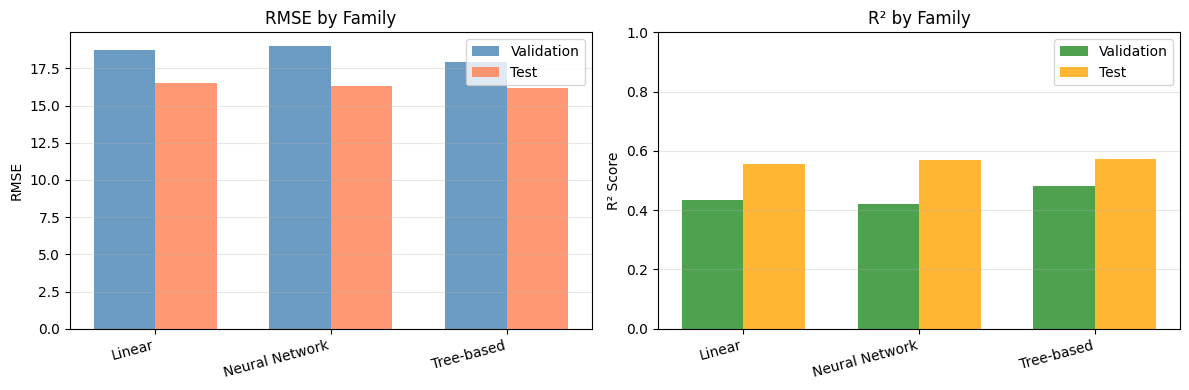


 Saved to family_comparison_summary.json


In [17]:

# Define model families
MODEL_FAMILIES = {
    'Linear': ['SVR', 'PolynomialRegression', 'LinearRegression'],
    'Neural Network': ['TorchMLP', 'TabNet'],
    'Tree-based': ['XGBoost', 'RandomForest', 'LightGBM']
}


if 'all_results_df' not in globals() or all_results_df.empty:
    print("⚠️  Run model comparison cell first")
else:
    val_df = all_results_df.xs('Valid', level='Dataset').copy()
    family_results = []
    
    # Find best model per family
    for family, models in MODEL_FAMILIES.items():
        available = [m for m in models if m in val_df.index]
        if not available:
            continue
        
        best_model = val_df.loc[available, 'RMSE'].idxmin()
        val_metrics = val_df.loc[best_model]
        
        try:
            test_metrics = all_results_df.loc[(best_model, 'Test')]
            gap = abs(test_metrics['RMSE'] - val_metrics['RMSE']) / val_metrics['RMSE'] * 100
        except KeyError:
            test_metrics = None
            gap = np.nan
        
        family_results.append({
            'Family': family,
            'Model': best_model,
            'Val_RMSE': val_metrics['RMSE'],
            'Val_R²': val_metrics['R2'],
            'Test_RMSE': test_metrics['RMSE'] if test_metrics is not None else np.nan,
            'Test_R²': test_metrics['R2'] if test_metrics is not None else np.nan,
            'Gap_%': gap
        })
    
    # Display results
    if family_results:
        df_compare = pd.DataFrame(family_results).set_index('Family')
        
        print("="*70)
        print("FAMILY CHAMPIONS COMPARISON")
        print("="*70)
        display(df_compare.round(4))
        
        best_family = df_compare['Val_RMSE'].idxmin()
        print(f"\n🏆 Best Family: {best_family} ({df_compare.loc[best_family, 'Model']})")
        print(f"   RMSE: {df_compare.loc[best_family, 'Val_RMSE']:.4f} | R²: {df_compare.loc[best_family, 'Val_R²']:.4f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # RMSE comparison
        x = np.arange(len(df_compare))
        width = 0.35
        ax1 = axes[0]
        ax1.bar(x - width/2, df_compare['Val_RMSE'], width, label='Validation', color='steelblue', alpha=0.8)
        ax1.bar(x + width/2, df_compare['Test_RMSE'], width, label='Test', color='coral', alpha=0.8)
        ax1.set_ylabel('RMSE')
        ax1.set_title('RMSE by Family')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df_compare.index, rotation=15, ha='right')
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
        
        # R² comparison
        ax2 = axes[1]
        ax2.bar(x - width/2, df_compare['Val_R²'], width, label='Validation', color='forestgreen', alpha=0.8)
        ax2.bar(x + width/2, df_compare['Test_R²'], width, label='Test', color='orange', alpha=0.8)
        ax2.set_ylabel('R² Score')
        ax2.set_title('R² by Family')
        ax2.set_xticks(x)
        ax2.set_xticklabels(df_compare.index, rotation=15, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        ax2.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()
        
        # Save summary
        summary = {
            'best_family': best_family,
            'best_model': df_compare.loc[best_family, 'Model'],
            'family_comparison': df_compare.to_dict(orient='index')
        }
        
        try:
            def convert(obj):
                if isinstance(obj, (np.integer, np.floating)):
                    return float(obj)
                if isinstance(obj, dict):
                    return {k: convert(v) for k, v in obj.items()}
                return obj
            
            with open(MODEL_DIR / 'family_comparison_summary.json', 'w') as f:
                json.dump(convert(summary), f, indent=2)
            print(f"\n Saved to family_comparison_summary.json")
        except Exception as e:
            print(f"Save failed: {e}")
    else:
        print("No models found for comparison")

Found metadata for: XGBoost, RandomForest, SVR, LinearRegression


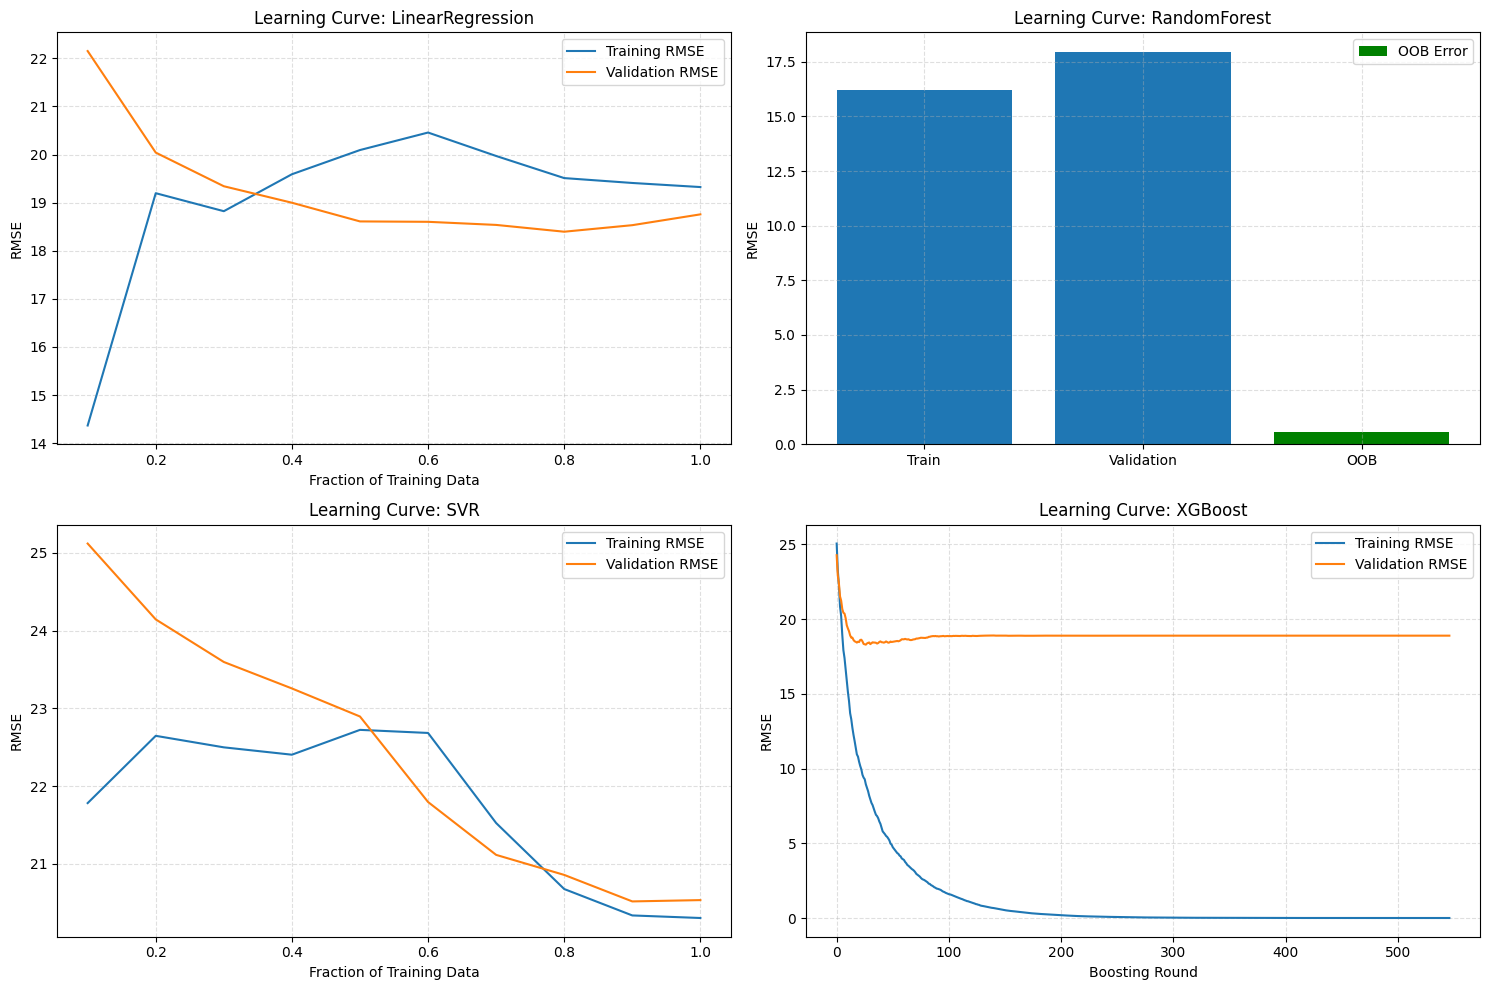

In [18]:
# Learning Curve Plotting (robust against missing metadata)
# Builds model_metadata from any *_meta globals produced during auto-load.

# Assemble model metadata dynamically
DISPLAY_NAME_MAP = {
    'xgb_model': 'XGBoost',
    'rf_model': 'RandomForest',
    'mlp_model': 'TorchMLP',
    'svr_model': 'SVR',
    'lr_model': 'LinearRegression'
}

model_metadata = {}
for name, obj in list(globals().items()):
    if name.endswith('_meta') and isinstance(obj, dict):
        base_var = name[:-5]  # strip '_meta'
        if base_var not in ['poly_model', 'tabnet_model']:  # exclude unsupported
            display_name = DISPLAY_NAME_MAP.get(base_var, base_var)
            model_metadata[display_name] = obj

if not model_metadata:
    print("⚠️  No model metadata dictionaries (*_meta) found. Run the model auto‑load/training cells first.")
else:
    print(f"Found metadata for: {', '.join(model_metadata.keys())}")


def plot_learning_curves(model_name, metadata, ax):
    learning_curves = metadata.get('learning_curves')
    if not learning_curves:
        ax.text(0.5, 0.5, 'No learning curve data', ha='center', va='center')
        ax.set_title(f'{model_name} - No Data')
        ax.axis('off')
        return

    # XGBoost format
    if 'validation_0' in learning_curves and 'validation_1' in learning_curves:
        try:
            train_rmse = learning_curves['validation_0']['rmse']
            val_rmse = learning_curves['validation_1']['rmse']
            ax.plot(train_rmse, label='Training RMSE')
            ax.plot(val_rmse, label='Validation RMSE')
            ax.set_xlabel('Boosting Round')
        except Exception as e:
            ax.text(0.5, 0.5, f'Parse error: {e}', ha='center', va='center')
            ax.set_title(f'{model_name} - Parse Error')
            return
    # PyTorch MLP stored losses
    elif 'train_loss' in learning_curves and 'val_loss' in learning_curves:
        train_loss = np.sqrt(learning_curves['train_loss'])
        val_loss = np.sqrt(learning_curves['val_loss'])
        ax.plot(train_loss, label='Training RMSE')
        ax.plot(val_loss, label='Validation RMSE')
        ax.set_xlabel('Epoch')
    # Generic sklearn manual format (possibly with train_sizes)
    elif 'train_rmse' in learning_curves and 'val_rmse' in learning_curves:
        train_rmse = learning_curves['train_rmse']
        val_rmse = learning_curves['val_rmse']
        train_sizes = learning_curves.get('train_sizes')
        if train_sizes:
            ax.plot(train_sizes, train_rmse, label='Training RMSE')
            ax.plot(train_sizes, val_rmse, label='Validation RMSE')
            ax.set_xlabel('Fraction of Training Data')
        else:  # RandomForest simple single-point
            # Use bar plot for single measurement
            labels = ['Train', 'Validation']
            values = [train_rmse[0] if isinstance(train_rmse, (list, tuple)) else train_rmse,
                      val_rmse[0] if isinstance(val_rmse, (list, tuple)) else val_rmse]
            ax.bar(labels, values)
            if 'oob_error' in learning_curves:
                oob_val = learning_curves['oob_error']
                if isinstance(oob_val, (list, tuple)):
                    oob_val = oob_val[0]
                if oob_val is not None:
                    ax.bar(['OOB'], [oob_val], color='green', label='OOB Error')
    else:
        ax.text(0.5, 0.5, 'Unrecognized curve format', ha='center', va='center')
        ax.set_title(f'{model_name} - Unknown Format')
        ax.axis('off')
        return

    ax.set_title(f'Learning Curve: {model_name}')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

# Plotting block
num_models = len(model_metadata)
if num_models == 0:
    print("No plots generated.")
else:
    ncols = 2
    nrows = max(1, math.ceil(num_models / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, (name, meta) in enumerate(sorted(model_metadata.items())):
        if i >= len(axes):
            break
        plot_learning_curves(name, meta, axes[i])

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [19]:
# Feature Importance (native if available, else permutation)
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

if best_model_obj is None:
    print('Best model object not available; run previous cells.')
else:
    # Try native importances
    importances = None
    importance_type = None
    try:
        if hasattr(best_model_obj, 'feature_importances_'):
            importances = getattr(best_model_obj, 'feature_importances_')
            importance_type = 'feature_importances_'
        elif hasattr(best_model_obj, 'coef_'):
            coef = getattr(best_model_obj, 'coef_')
            # Flatten if necessary
            importances = np.abs(coef.ravel())
            importance_type = 'coef_'
    except Exception as e:
        print('[Importance] Native extraction failed:', e)

    if importances is None or len(importances) != len(feature_names):
        print('[Importance] Falling back to permutation importance (n_repeats=10).')
        try:
            perm = permutation_importance(best_model_obj, X_valid_enc, y_valid, n_repeats=10, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
            importances = np.maximum(0, perm.importances_mean)
            importance_type = 'permutation_neg_rmse'
        except Exception as e:
            print('[Importance] Permutation importance failed:', e)
            importances = None

    if importances is not None:
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
        # Plot
        top_plot = fi_df.head(25).iloc[::-1]
        plt.figure(figsize=(6, 4))
        bars = plt.barh(top_plot['feature'], top_plot['importance'], color='steelblue')
        plt.title(f'Top Feature Importances ({importance_type}) - {best_model_name_runtime}')
        plt.xlabel('Importance')
        
        # Add value labels on the bars
        for bar, value in zip(bars, top_plot['importance']):
            plt.text(bar.get_width() + max(top_plot['importance']) * 0.01, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{value:.2f}', 
                    ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print('Could not compute feature importance.')

Best model object not available; run previous cells.


## SHAP BAR SHAP beeswarm

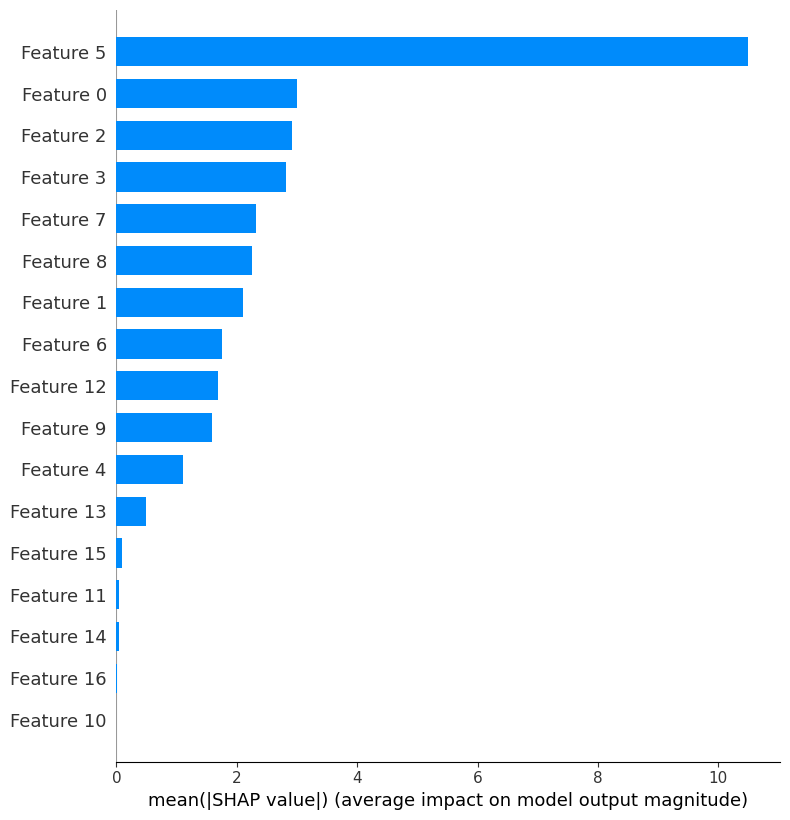

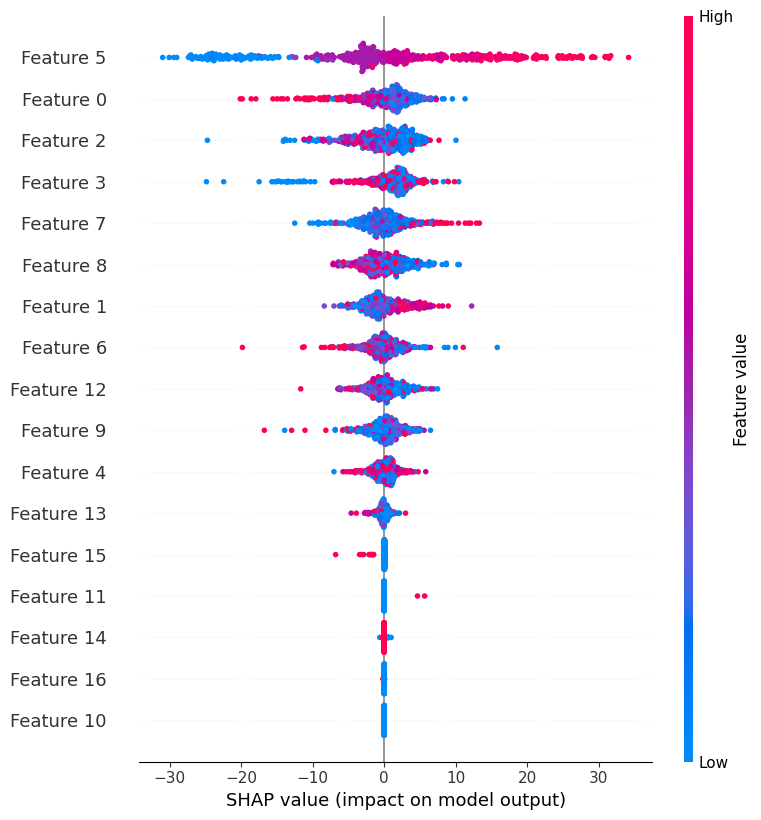

ValueError: Could not find feature named: num__read_high_pct

In [20]:
import shap

# Create explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_enc)

# Summary plot: global feature importance with direction
shap.summary_plot(shap_values, X_train_enc, plot_type="bar")

# Detailed plot: shows positive/negative impacts
shap.summary_plot(shap_values, X_train_enc)

# Dependence plot: sensitivity of specific feature
shap.dependence_plot(
    "num__read_high_pct", 
    shap_values, 
    X_train_enc,
    feature_names=feature_names,
    interaction_index="num__math_counts"  # optional: show interactions
)

# For a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_train_enc.iloc[0])

# Waterfall plot for one instance
shap.waterfall_plot(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_train_enc.iloc[0],
    feature_names=X_train_enc.columns.tolist()
))

## Failure Analysis

Select at least 3 specific examples where prediction failed, analyze reasons, and suggest improvements.

Performing Sensitivity Analysis on Best Model
Model: RandomForest
Analyzing sensitivity of top 5 features: ['num__read_high_pct', 'num__math_counts', 'num__grade_eight_enrollment', 'num__avg_natwalkind', 'num__total_pop']

=== Sensitivity Analysis Results ===


,feature,value,rmse,delta_rmse
0,num__read_high_pct,-1.878652,34.183274,16.228831
1,num__read_high_pct,-0.089330,25.138191,7.183748
2,num__read_high_pct,0.688636,26.432587,8.478144
3,num__read_high_pct,1.272110,30.463035,12.508592
4,num__math_counts,-0.789482,19.652752,1.698309
5,num__math_counts,-0.686064,18.273719,0.319276
6,num__math_counts,-0.644697,18.244928,0.290485
7,num__math_counts,0.720422,18.240404,0.285961
8,num__math_counts,1.154778,18.262297,0.307855
9,num__grade_eight_enrollment,-1.016860,18.349171,0.394728


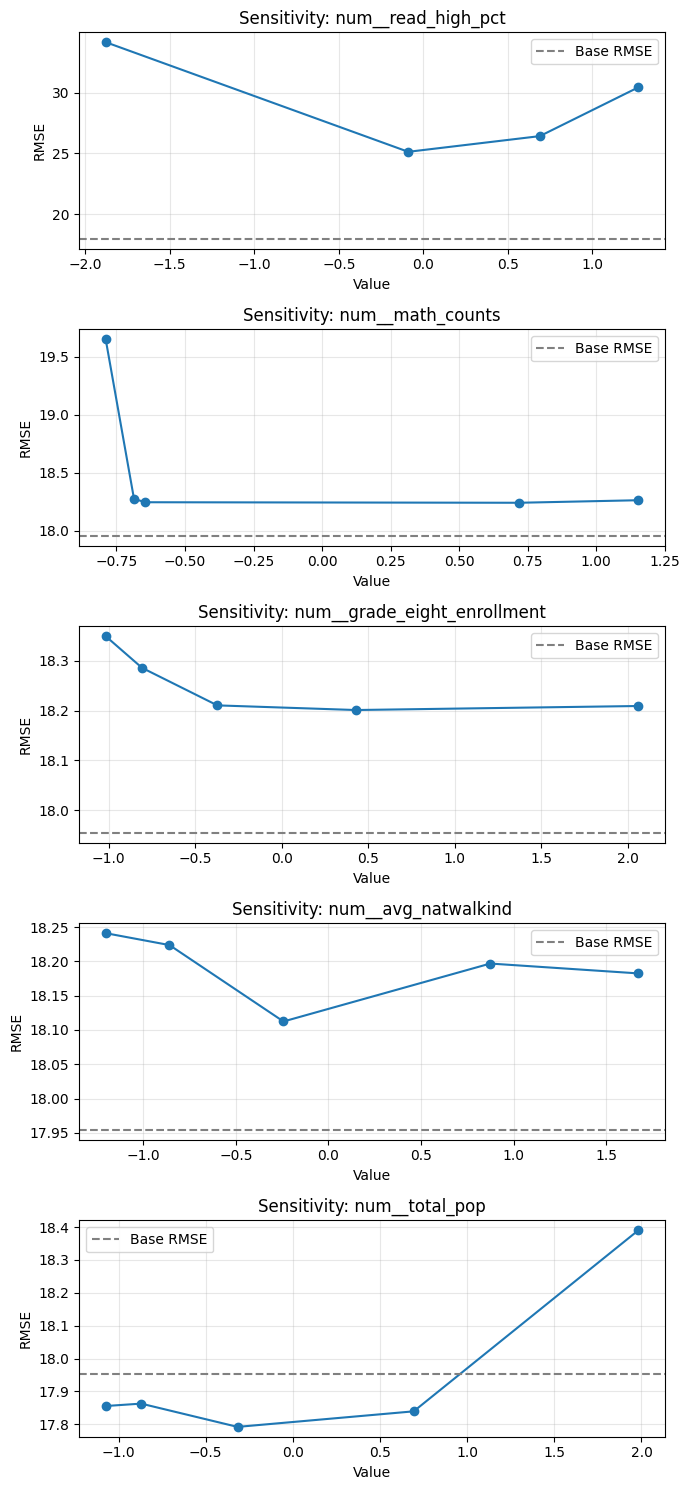


=== Trade-offs Analysis ===
(Higher sensitivity_score => larger RMSE movement per unit importance)


,feature,importance,rmse_range,sensitivity_score
1,num__math_counts,0.068149,1.412348,20.724505
0,num__read_high_pct,0.600107,9.045083,15.072452
4,num__total_pop,0.040256,0.598165,14.859129
3,num__avg_natwalkind,0.048708,0.128666,2.641606
2,num__grade_eight_enrollment,0.058297,0.148206,2.542272



✓ Saved explainability analysis -> best_model_explainability.json


In [ ]:
# Sensitivity Analysis: How sensitive are results to feature perturbations?
if 'best_model_obj' in globals() and best_model_obj is not None and 'fi_df' in globals() and 'feature_names' in globals():
    print('Performing Sensitivity Analysis on Best Model')
    print(f'Model: {best_model_name_runtime}')
    
    # Parameters
    TOP_N_SENS = 5
    TOP_N_SENS = min(TOP_N_SENS, len(fi_df))
    top_sens_features = fi_df.head(TOP_N_SENS)['feature'].tolist()
    print(f'Analyzing sensitivity of top {TOP_N_SENS} features: {top_sens_features}')

    # Ensure dense matrix for perturbations
    X_valid_dense = X_valid_enc.toarray() if hasattr(X_valid_enc, 'toarray') else np.asarray(X_valid_enc)
    base_preds = best_model_obj.predict(X_valid_dense)
    base_rmse = root_mean_squared_error(y_valid, base_preds)
    sens_records = []

    for feat in top_sens_features:
        if feat not in feature_names:
            continue
        col_idx = feature_names.index(feat)
        col_values = X_valid_dense[:, col_idx]
        unique_vals = np.unique(col_values)
        # Build grid: handle near-constant / binary / continuous
        if len(unique_vals) <= 2:
            grid = unique_vals
        else:
            # Use robust quantiles; drop duplicates if feature has low variance
            grid = np.unique(np.quantile(col_values, [0.05, 0.25, 0.5, 0.75, 0.95]))
        for gv in grid:
            X_mod = X_valid_dense.copy()
            X_mod[:, col_idx] = gv
            try:
                preds_mod = best_model_obj.predict(X_mod)
                rmse_mod = root_mean_squared_error(y_valid, preds_mod)
            except Exception as e:
                rmse_mod = np.nan
            sens_records.append({
                'feature': feat,
                'value': float(gv),
                'rmse': rmse_mod,
                'delta_rmse': (rmse_mod - base_rmse) if not np.isnan(rmse_mod) else np.nan
            })

    sens_df = pd.DataFrame(sens_records)
    print('\n=== Sensitivity Analysis Results ===')
    display(sens_df.head(20))

    # Plot curves
    if not sens_df.empty:
        n_feat = len(top_sens_features)
        fig, axes = plt.subplots(n_feat, 1, figsize=(7, 3 * n_feat), sharex=False)
        if n_feat == 1:
            axes = [axes]
        for ax, feat in zip(axes, top_sens_features):
            sub = sens_df[sens_df['feature'] == feat].sort_values('value')
            if sub.empty:
                ax.set_title(f'Sensitivity: {feat} (no data)')
                continue
            ax.plot(sub['value'], sub['rmse'], marker='o')
            ax.axhline(base_rmse, color='gray', linestyle='--', label='Base RMSE')
            ax.set_title(f'Sensitivity: {feat}')
            ax.set_xlabel('Value')
            ax.set_ylabel('RMSE')
            ax.legend()
            ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print('No sensitivity records to plot.')

    # Trade-offs summary
    trade_rows = []
    for feat in top_sens_features:
        sub = sens_df[sens_df['feature'] == feat]
        if sub.empty:
            continue
        rmse_range = sub['rmse'].max() - sub['rmse'].min()
        imp_row = fi_df.loc[fi_df['feature'] == feat, 'importance']
        imp_val = float(imp_row.iloc[0]) if not imp_row.empty else np.nan
        trade_rows.append({
            'feature': feat,
            'importance': imp_val,
            'rmse_range': rmse_range,
            'sensitivity_score': rmse_range / (imp_val + 1e-9) if not np.isnan(imp_val) else np.nan
        })
    trade_df = pd.DataFrame(trade_rows).sort_values('sensitivity_score', ascending=False)
    print('\n=== Trade-offs Analysis ===')
    print('(Higher sensitivity_score => larger RMSE movement per unit importance)')
    display(trade_df)

    # Persist artifacts
    analysis_payload = {
        'feature_importances': fi_df.to_dict(orient='records') if 'fi_df' in globals() else None,
        'ablation': ablation_df.to_dict(orient='records') if 'ablation_df' in globals() else None,
        'sensitivity': sens_df.to_dict(orient='records'),
        'tradeoffs': trade_df.to_dict(orient='records'),
        'best_model': best_model_name_runtime if 'best_model_name_runtime' in globals() else None,
        'base_validation_rmse': float(base_rmse)
    }
    analysis_path = MODEL_DIR / 'best_model_explainability.json'
    try:
        with open(analysis_path, 'w') as f:
            json.dump(analysis_payload, f, indent=2)
        print(f'\n✓ Saved explainability analysis -> {analysis_path.name}')
    except Exception as e:
        print(f'Failed to save explainability JSON: {e}')

else:
    print('Prerequisites missing for sensitivity analysis. Run model comparison and feature importance first.')



FAILURE ANALYSIS
Performing Failure Analysis on Test Set
Top 10 largest prediction errors:


,actual,predicted,error,abs_error
school_name,,,,
Pelham City Middle School,5.0,45.6880,40.6880,40.6880
YEARLING MIDDLE SCHOOL,79.0,38.4588,40.5412,40.5412
DeKalb Preparatory Academy Charter,49.0,9.5325,39.4675,39.4675
Crews Middle School,79.0,39.9746,39.0254,39.0254
Rock Falls Middle School,3.0,41.9969,38.9969,38.9969
Summit Academy RSSP,49.0,10.2663,38.7337,38.7337
SC Connections Academy,49.0,14.2079,34.7921,34.7921
Kelloggsville Middle School,9.0,43.4409,34.4409,34.4409
Sudbrook Magnet Middle,5.0,39.1420,34.1420,34.1420



=== Detailed Failure Analysis ===

--- Failure Example 1 ---
Index: Pelham City Middle School
Actual: 5.0000
Predicted: 45.6880
Absolute Error: 40.6880
Feature values:
  school_type: 1
  teachers_fte: 26.0
  enrollment: 315.0
  grade_eight_enrollment: 105.0
  math_counts: 8.0
  read_counts: 8.0
  read_high_pct: 49.0
  pct_hhi_150k_200k: 0.25
  pct_hhi_220k_plus: 0.48
  avg_natwalkind: 5.425925925555555
  total_10_14: 605
  pct_10_14: 0
  pct_female_10_14: 0.0
  total_pop: 9575
  schools_in_zip: 4
Category: Extreme Outlier Failure
Possible Reason: Prediction error is in the top 5% of all errors, indicating the model struggles with extreme cases.
Suggested Improvement: Collect more data for extreme value ranges, or use robust regression techniques.

--- Failure Example 2 ---
Index: YEARLING MIDDLE SCHOOL
Actual: 79.0000
Predicted: 38.4588
Absolute Error: 40.5412
Feature values:
  school_type: 1
  teachers_fte: 41.0
  enrollment: 683.0
  grade_eight_enrollment: 230.0
  math_counts: 94.0


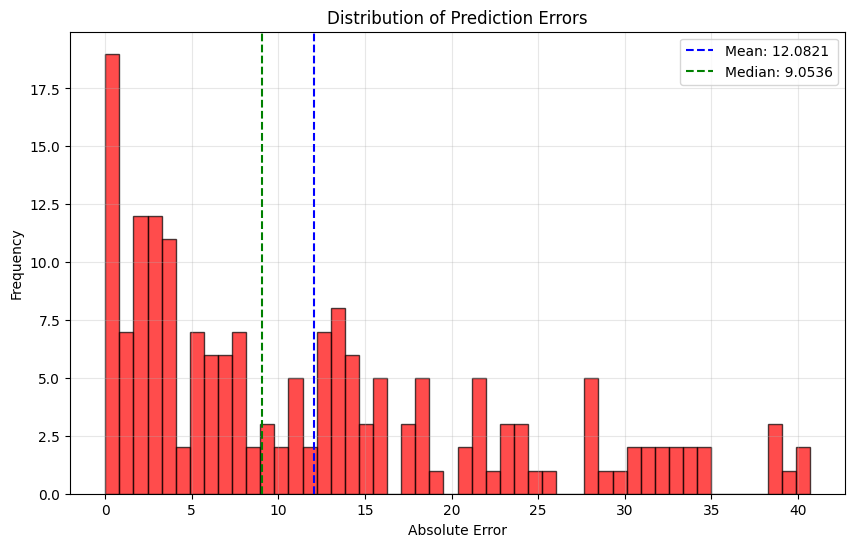

In [ ]:

# Failure Analysis: Analyze specific prediction failures
print('\n' + '='*50)
print('FAILURE ANALYSIS')
print('='*50)

if 'best_model_obj' in globals() and best_model_obj is not None and 'X_test' in globals() and 'y_test' in globals():
    print('Performing Failure Analysis on Test Set')
    
    # Get predictions
    if 'X_test_enc' in globals():
        test_preds = best_model_obj.predict(X_test_enc)
    else:
        # Fallback if encoding not available
        test_preds = best_model_obj.predict(X_test)
    
    # Calculate errors
    errors = np.abs(test_preds - y_test.values)
    error_df = pd.DataFrame({
        'actual': y_test,
        'predicted': test_preds,
        'error': errors,
        'abs_error': np.abs(errors)
    })
    
    # Sort by largest errors
    error_df = error_df.sort_values('abs_error', ascending=False)
    
    print(f'Top 10 largest prediction errors:')
    display(error_df.head(10).round(4))
    
    # Select 3 specific examples for detailed analysis
    failure_examples = error_df.head(3).copy()
    
    print('\n=== Detailed Failure Analysis ===')
    for i, (idx, row) in enumerate(failure_examples.iterrows(), 1):
        print(f'\n--- Failure Example {i} ---')
        print(f'Index: {idx}')
        print(f'Actual: {row["actual"]:.4f}')
        print(f'Predicted: {row["predicted"]:.4f}')
        print(f'Absolute Error: {row["abs_error"]:.4f}')
        
        # Get original features for this example
        if idx in X_test.index:
            example_features = X_test.loc[idx]
            print('Feature values:')
            for feat, val in example_features.items():
                print(f'  {feat}: {val}')
        
        # Categorize failure
        if row['abs_error'] > error_df['abs_error'].quantile(0.95):
            category = 'Extreme Outlier Failure'
            reason = 'Prediction error is in the top 5% of all errors, indicating the model struggles with extreme cases.'
            improvement = 'Collect more data for extreme value ranges, or use robust regression techniques.'
        elif row['predicted'] > row['actual'] * 1.5:
            category = 'Severe Overestimation'
            reason = 'Model significantly overestimates the target value.'
            improvement = 'Check for feature scaling issues, or add regularization to prevent overfitting.'
        elif row['actual'] > row['predicted'] * 1.5:
            category = 'Severe Underestimation'
            reason = 'Model significantly underestimates the target value.'
            improvement = 'May indicate missing important features or non-linear relationships not captured.'
        else:
            category = 'Moderate Error'
            reason = 'Prediction is reasonably close but still has notable error.'
            improvement = 'Fine-tune hyperparameters or ensemble with other models.'
        
        print(f'Category: {category}')
        print(f'Possible Reason: {reason}')
        print(f'Suggested Improvement: {improvement}')
    
    # Summary statistics
    print(f'\n=== Failure Summary ===')
    print(f'Mean Absolute Error: {error_df["abs_error"].mean():.4f}')
    print(f'Median Absolute Error: {error_df["abs_error"].median():.4f}')
    print(f'95th Percentile Error: {error_df["abs_error"].quantile(0.95):.4f}')
    print(f'Max Error: {error_df["abs_error"].max():.4f}')
    
    # Distribution of errors
    plt.figure(figsize=(10, 6))
    plt.hist(error_df['abs_error'], bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(error_df['abs_error'].mean(), color='blue', linestyle='--', label=f'Mean: {error_df["abs_error"].mean():.4f}')
    plt.axvline(error_df['abs_error'].median(), color='green', linestyle='--', label=f'Median: {error_df["abs_error"].median():.4f}')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
else:
    print('Prerequisites missing for failure analysis. Run model training and testing first.')